<h1>Hawkes Clustering EM</h1><br>
Allows for modelling a dataset as a Hawkes process with an EM (parametric estimator) kernel. The dataset is first broken down into clusters of events before the model is applied to it.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from HelperFunctions import Clusterise, MultiHist, InterTimes, ComputeClusterLengths, GenerateClusters
from TickHelper import TrainInnerClusterEM, SimulateEM, SavedModel
import os

c:\users\ricard grace\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#convenience variables
sec = 1000000000

#tweakable parameters
data_csv = 'data.csv'
c_id = 4
cluster_size = 12.5 #the amount of seconds of silence before declaring a cluster border. 12.5 seems to work well for client 4
k_time = 36 #length of time the kernel should consider. Should be long enough to capture most interarrivals
k_size = 72 #how many intervals in the kernel

#files
#saved model = f"HawkesEM_{k_size}_cluster_model_c{c_id}.npz" # do not change here
dist_folder = "saved_dist"
model_folder = "saved_model"

<h2>Data Loading</h2>

In [3]:
#load raw data
X = pd.read_csv(data_csv)
X1 = X[(X.client_id == c_id) & (X.from_ds == 0)].time.apply(lambda x:x/sec)
X2 = X[(X.client_id == c_id) & (X.from_ds == 1)].time.apply(lambda x:x/sec)
maxtime = X1.max()
m = X2.max()
if (m > maxtime):
    maxtime = m
print(f"Max Time: {maxtime}")
print(f"Num Points: {len(X1) + len(X2)}")

#create multivariate process
data = [X1.astype(np.dtype('d')).to_numpy(), X2.astype(np.dtype('d')).to_numpy()]

Max Time: 244608.309583663
Num Points: 284553


<h2>Clustering</h2>

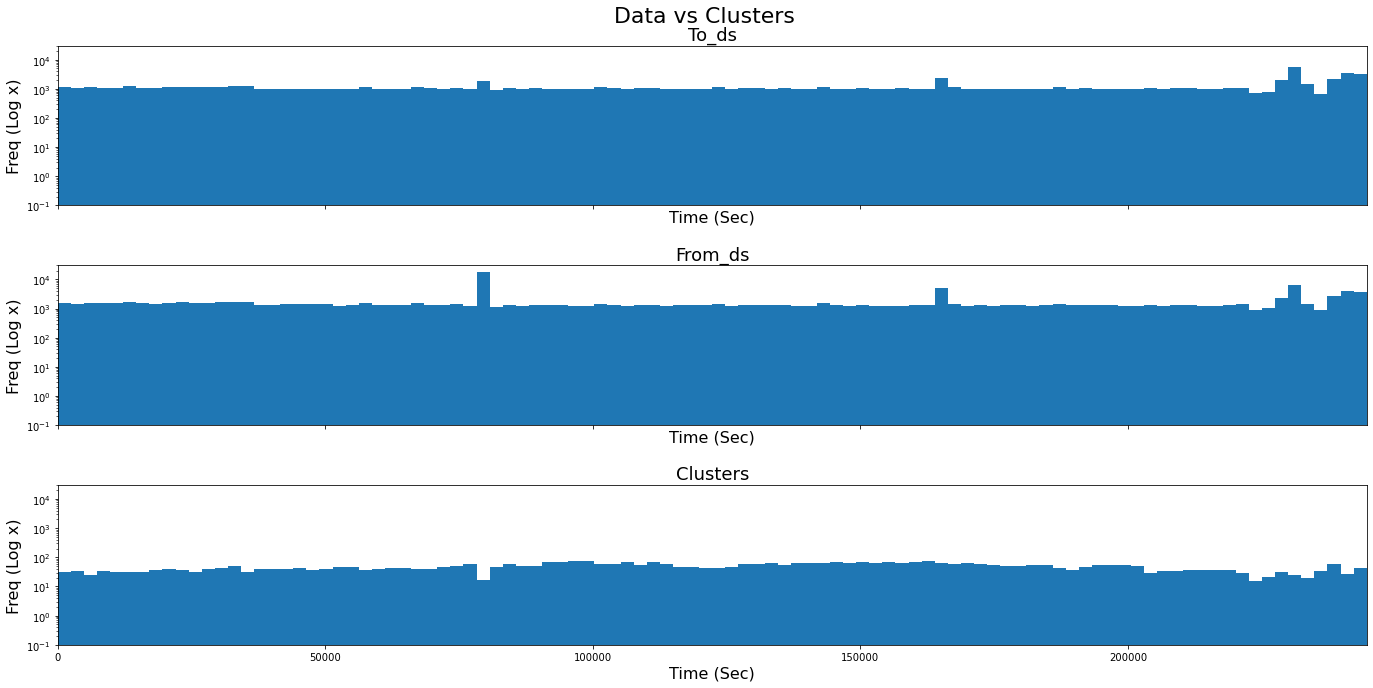

In [4]:
#cluster the data
clusters = []
inner_cluster_times = []
clusters, inner_cluster_times = Clusterise(data, cluster_size)

#create cluster distribution histogram
MultiHist([data[0], data[1], clusters], title='Data vs Clusters', subtitles=['To_ds', 'From_ds', 'Clusters'], bins=100, y_max=30000)

<h2>Training</h2><br>
Depending on settings can take anywhere from minutes to hours. The default settings for client4 run for about 30 mins

Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     7.82e-01 |   8.41e-01
       10 |     1.91e-02 |   8.27e-03
       20 |     6.29e-04 |   1.70e-03
       30 |     2.04e-03 |   1.07e-03
       40 |     9.53e-04 |   4.55e-04
       50 |     4.18e-04 |   2.03e-04
       60 |     1.79e-04 |   9.63e-05
       70 |     7.06e-05 |   5.01e-05
       80 |     2.63e-05 |   3.08e-05
       90 |     8.28e-06 |   2.20e-05
      100 |     2.18e-06 |   1.70e-05
      110 |     3.40e-06 |   1.37e-05
      120 |     4.64e-06 |   1.16e-05
      130 |     6.28e-06 |   1.06e-05
      140 |     9.02e-06 |   1.07e-05
      150 |     1.25e-05 |   1.19e-05
      160 |     1.59e-05 |   1.36e-05
      170 |     1.83e-05 |   1.51e-05
      180 |     1.90e-05 |   1.59e-05
      190 |     1.79e-05 |   1.59e-05
      200 |     1.54e-05 |   1.50e-05
      210 |     1.22e-05 |   1.35e-05
      220 |     9.07e-06 |   1.18e-05
      230 |     6.36e-06 |   1.01e-05
      240 |     4

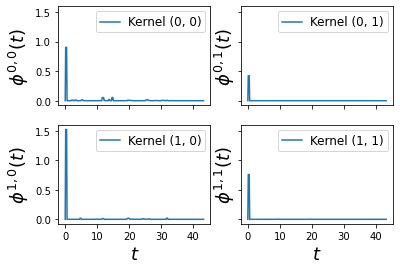

In [5]:
em_learner = TrainInnerClusterEM(inner_cluster_times, k_time=k_time, k_size=k_size)

<h2>Simulation</h2>

In [6]:
#save the model
smodel = SavedModel(em_learner, k_time, k_size)
fname = os.path.join(model_folder, f"HawkesEM_{k_size}_cluster_model_c{c_id}.npz")
smodel.Save(fname)

#extract important information
em_kernel = smodel.time_kernel
em_baseline = smodel.baseline
em_kernel, em_baseline

#generate statistics on the length of clusters
cluster_lengths = ComputeClusterLengths(inner_cluster_times)
print(f"Median Length: {cluster_lengths[int(len(cluster_lengths)/2)]}")
#generate new clusters using the computed lengths
source_clusters = len(inner_cluster_times)
sim_clusters_goal = source_clusters * 2
sim_clusters = 0
sim_inner_cluster_times = []
print(f"Source Clusters: {source_clusters}\nGeneration Goal: {sim_clusters_goal}")

success = True
#try and perform the simulation - many times does not succeed
try:
    sim_timestamps = SimulateEM(em_kernel, em_baseline, time=200000)
except ValueError:
    print("\nThe model created is probably invalid and thus cannot be simulated. This is a problem frequently encountered with the clustering approach, the learner does not seem to produce a stable (terminating) process. Spectral radius >= 1\n")
    success = False
    
#print(f"Simulated {sim_clusters} clusters")

Median Length: 40.44991493198904
Source Clusters: 4748
Generation Goal: 9496
Simulated 27965 points
Simulated 0 clusters


<h2>Evaluation</h2>

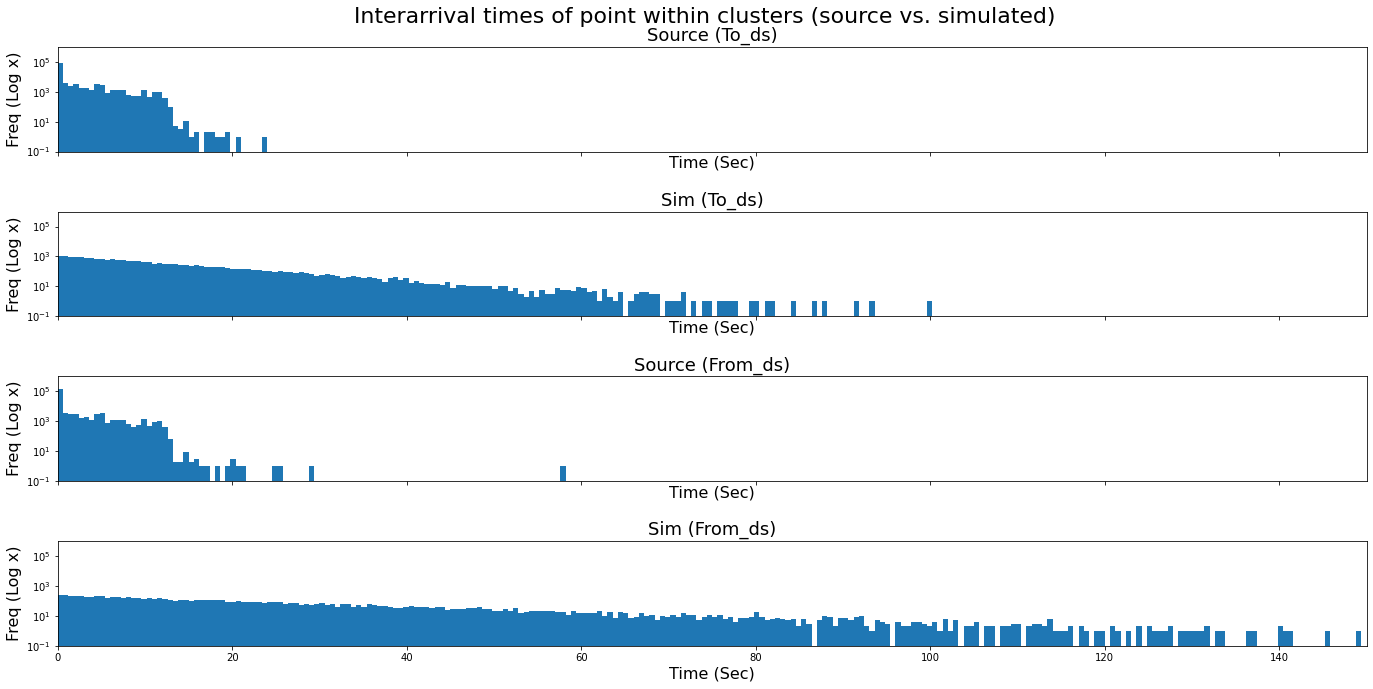

In [12]:
if (success):
    #prepare simulation data for graphing
    interarr = [[],[]]
    for cluster in inner_cluster_times:
        i = 0
        for series in cluster:
            interarr[i].extend(InterTimes(series))
            i += 1
    interarr[0].sort()
    interarr[1].sort()

    sim_interarr = []
    for cluster in sim_timestamps:
        sim_interarr.append(InterTimes(cluster))
    sim_interarr[0].sort()
    sim_interarr[1].sort()

    MultiHist([interarr[0], sim_interarr[0], interarr[1], sim_interarr[1]], title="Interarrival times of point within clusters (source vs. simulated)", subtitles=['Source (To_ds)','Sim (To_ds)','Source (From_ds)','Sim (From_ds)'], data_range=(0,150), y_max=1000000)
    
    #save the simulation
    fname = os.path.join(dist_folder, f"HawkesEM_{k_size}_cluster_dist_c{c_id}.npz")
    np.savez(fname, deltas=sim_interarr)
else:
    print("Did not successfully simulate new points, cannot perform evaluation")